## 日経平均予測
### 翌営業日の日経平均終値に対する単純騰落予測（上がるか／下がるか）、
### および４パターン増減予測（①1%以上 ②0%以上、1%未満　 ③-1%以上、0%未満　 ④-1%超）を行う。

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import csv
import time
import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam
from __future__ import print_function
from sklearn.model_selection import train_test_split, GridSearchCV
from IPython.display import display
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report
from sklearn.metrics import confusion_matrix

C:\Users\yt690\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### CSVファイル読み込み

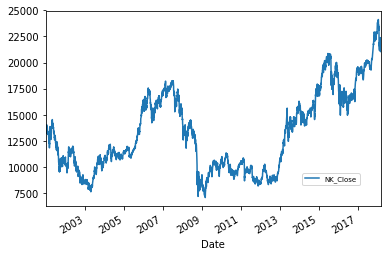

,NK_Close
count,4212.000000
mean,13258.716387
std,3830.598834
min,7054.980000
25%,9999.692500
50%,12241.785000
75%,16313.537500
max,24124.150000


In [2]:
# 学習データの読み込み
df = pd.read_csv('mktdat_nk1.csv',encoding='utf-8',index_col='Date', parse_dates=[0])

#データ確認
df.head() 
df.plot()
plt.legend(bbox_to_anchor=(1, 0), loc='lower right', borderaxespad=3, fontsize=7)
plt.show()
df.describe()

### データ加工

In [3]:
#増減率（100＊log（前日比））を計算し、新たな列を追加

for i in range(len(df.columns)):
    use_col = df.columns[i]
    df[use_col] =  100*np.log(df[use_col]/df[use_col].shift())

#前日比をとったので、先頭行にNaNが含まれるため、先頭行を削除
df=df.dropna(how='any')

df.describe()

,NK_Close
count,4211.000000
mean,0.010138
std,1.523779
min,-12.111026
25%,-0.728694
50%,0.042793
75%,0.826839
max,13.234585


In [4]:
#標準化
df = (df - df.mean()) / df.std(ddof=0)

df.describe()

,NK_Close
count,4.211000e+03
mean,-2.697122e-17
std,1.000119e+00
min,-7.955617e+00
25%,-4.849263e-01
50%,2.143279e-02
75%,5.360340e-01
max,8.679746e+00


In [5]:
#日経平均終値の増減率を4パターンに分類
df['NK_Close_P1'] = df['NK_Close'] >=1  
df['NK_Close_P2'] =  (0 == df['NK_Close']) | (0 < df['NK_Close']) & (df['NK_Close']<1)
df['NK_Close_P3'] =  (-1<= df['NK_Close']) & (df['NK_Close']<0)
df['NK_Close_P4'] = df['NK_Close']<-1

df['NK_Close_P1'] = df['NK_Close_P1'].astype(np.int)
df['NK_Close_P2'] = df['NK_Close_P2'].astype(np.int)
df['NK_Close_P3'] = df['NK_Close_P3'].astype(np.int)
df['NK_Close_P4'] = df['NK_Close_P4'].astype(np.int)
df.head()

,NK_Close,NK_Close_P1,NK_Close_P2,NK_Close_P3,NK_Close_P4
Date,,,,,
2001-01-09,-1.234906,0,0,0,1
2001-01-10,-0.870004,0,0,1,0
2001-01-11,-1.148059,0,0,0,1
2001-01-12,0.718550,0,1,0,0
2001-01-15,0.768089,0,1,0,0


In [6]:
# 学習データ
x_data = np.array(df.iloc[:,0:(len(df.columns)-4)].astype(np.float))

# ラベルデータ（増減率４パターン）
y_data = np.array(df.iloc[:,(len(df.columns)-4):].astype(np.float)) 

In [7]:
maxlen = 80              # 入力系列数
n_in = x_data.shape[1]   # 学習データ（＝入力）の列数
print("n_in:",n_in)
n_out = y_data.shape[1]  # ラベルデータ（=出力）の列数
print("n_out:",n_out)
len_seq = x_data.shape[0] - maxlen
print("x_data.shape[0]:",x_data.shape[0])
print("len_seq:",len_seq)

data = []
target = []
for i in range(0, len_seq):
  data.append(x_data[i:i+maxlen, :]) #80個ずつずらして取得
  target.append(y_data[i+maxlen, :])#80個目から取得

print("len(data):",len(data))
x = np.array(data).reshape(len(data), maxlen)
y = np.array(target).reshape(len(data), n_out)

print("x.shape:",x.shape, "y.shape:",y.shape)

n_in: 1
n_out: 4
x_data.shape[0]: 4211
len_seq: 4131
len(data): 4131
x.shape: (4131, 80) y.shape: (4131, 4)


In [8]:
%%time

#データを学習用とテスト用に分割 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1234)

print("X_train=",X_train)
print()
print("X_test=",X_test)
print()
print("y_train=",y_train)
print()
print("y_test=",y_test)

X_train= [[ 3.12774964e-01 -2.05954358e-01 -4.58675566e-01 ...  1.25167679e+00
  -1.90046872e-01 -4.27455253e-01]
 [-9.62571409e-02 -4.98501231e-01 -9.38752344e-01 ...  2.14284328e-01
   8.02581608e-01  2.43156124e-01]
 [ 7.80475120e-01 -1.47811828e+00  2.41351380e+00 ... -3.31773618e+00
   1.66394262e+00  2.05929222e-01]
 ...
 [-1.22689368e+00 -1.08609077e+00  1.27663715e+00 ... -1.11091587e+00
   2.71688378e-01 -1.18483160e+00]
 [ 2.03371591e+00 -1.39238813e+00 -1.16026281e+00 ...  3.90599641e-01
  -1.07410977e+00  7.89456680e-01]
 [-9.83240707e-04  1.42243664e+00 -2.35242896e-02 ...  4.50799593e-01
   1.81729577e+00 -5.56097523e-01]]

X_test= [[ 1.2609117  -0.09625714 -0.49850123 ... -0.15656243  0.21428433
   0.80258161]
 [ 0.04673557  1.17258516 -0.44985223 ... -0.05150277 -0.66001447
  -1.39177304]
 [ 1.28117281  0.59101141  0.73148767 ...  0.05414688 -0.50899228
  -0.78474224]
 ...
 [ 0.45059617  0.43857464  0.07392685 ... -0.31702074  0.36430654
  -0.70944759]
 [ 0.50883835 -0.

In [9]:
model = Sequential()
model.add(Dense(80, activation='relu', input_dim=80))
model.add(Dropout(0.5))
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))#最終層のactivationは変更しないこと
   
#sgd = SGD(lr=0.03, momentum=0.9, nesterov=False)    
#rms = RMSprop(lr=0.03)
# adag = Adagrad(lr=0.01)
adad = Adadelta(lr=0.03)
#adam = Adam(lr=0.03)

model.compile(loss='categorical_crossentropy',
              optimizer=adad,
              metrics=['accuracy'])

Train on 3717 samples, validate on 414 samples
Epoch 1/100
3717/3717 [==============================] - 1s - loss: 1.7749 - acc: 0.2421 - val_loss: 1.4445 - val_acc: 0.2633
Epoch 2/100
3717/3717 [==============================] - 0s - loss: 1.7184 - acc: 0.2572 - val_loss: 1.4105 - val_acc: 0.2923
Epoch 3/100
3717/3717 [==============================] - 0s - loss: 1.6776 - acc: 0.2585 - val_loss: 1.3872 - val_acc: 0.3188
Epoch 4/100
3717/3717 [==============================] - 0s - loss: 1.6549 - acc: 0.2790 - val_loss: 1.3698 - val_acc: 0.3357
Epoch 5/100
3717/3717 [==============================] - 0s - loss: 1.6132 - acc: 0.2865 - val_loss: 1.3574 - val_acc: 0.3406
Epoch 6/100
3717/3717 [==============================] - 0s - loss: 1.6034 - acc: 0.2989 - val_loss: 1.3494 - val_acc: 0.3527
Epoch 7/100
3717/3717 [==============================] - 0s - loss: 1.5818 - acc: 0.3153 - val_loss: 1.3441 - val_acc: 0.3671
Epoch 8/100
3717/3717 [==============================] - 0s - loss: 1.5

3717/3717 [==============================] - 0s - loss: 1.3942 - acc: 0.3783 - val_loss: 1.3254 - val_acc: 0.3841
Epoch 66/100
3717/3717 [==============================] - 0s - loss: 1.4169 - acc: 0.3678 - val_loss: 1.3254 - val_acc: 0.3889
Epoch 67/100
3717/3717 [==============================] - 0s - loss: 1.4082 - acc: 0.3707 - val_loss: 1.3250 - val_acc: 0.3889
Epoch 68/100
3717/3717 [==============================] - 0s - loss: 1.4107 - acc: 0.3672 - val_loss: 1.3250 - val_acc: 0.3841
Epoch 69/100
3717/3717 [==============================] - 0s - loss: 1.4067 - acc: 0.3667 - val_loss: 1.3246 - val_acc: 0.3841
Epoch 70/100
3717/3717 [==============================] - 0s - loss: 1.4210 - acc: 0.3780 - val_loss: 1.3243 - val_acc: 0.3841
Epoch 71/100
3717/3717 [==============================] - 0s - loss: 1.4075 - acc: 0.3699 - val_loss: 1.3241 - val_acc: 0.3865
Epoch 72/100
3717/3717 [==============================] - 0s - loss: 1.4102 - acc: 0.3694 - val_loss: 1.3239 - val_acc: 0.38

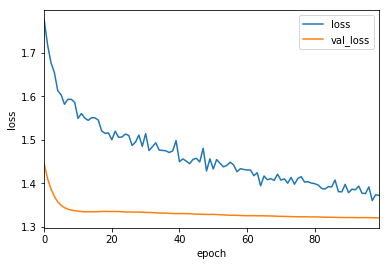

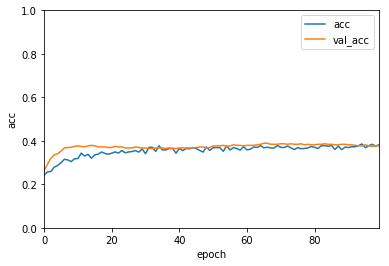

250/414 [=================>............] - ETA: 0sscore: [1.3204577003700146, 0.37681160122156143]
識別率（騰落４分類）: 0.37681
識別率（騰落）: 0.53382


In [10]:
# 学習
fit = model.fit(X_train, y_train,
          epochs=100,
          batch_size=10,validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

#テスト
score = model.evaluate(X_test, y_test, batch_size = 10, verbose = 1)
print("score:", score)
# 
#識別率（騰落４分類）
y_pred = model.predict(X_test)
correct = 0
semi_correct = 0
for i in range(len(y_pred)):
  pred = np.argmax(y_pred[i,:])
  tar = np.argmax(y_test[i,:])
  if pred == tar :
    correct += 1
  else :
    if pred+tar == 1 or pred+tar == 5 :
      semi_correct += 1

print("識別率（騰落４分類）: %6.5f" % (1.0 * correct / len(y_pred)))
print("識別率（騰落）: %6.5f" % (1.0 * (correct+semi_correct) / len(y_pred)))